<a href="https://www.kaggle.com/code/yogeshmodi04/sementic-segmentation-pcd?scriptVersionId=124849741" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.3 MB/s eta 0:00:00


In [2]:
!pip install --upgrade pip
!pip install -q tensorflow
!pip install -q keras

#Also try adding this line before importing segmentation_models

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [3]:
!pip install opencv-python==4.6.0.66
!pip install scikit-learn
!pip install libgl1-mesa-glx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
ERROR: Could not find a version that satisfies the requirement libgl1-mesa-glx (from versions: none)
ERROR: No matching distribution found for libgl1-mesa-glx


In [4]:
!apt-get update && apt-get install -y python3-opencv

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 http://packages.cloud.google.com/apt gcsfuse-focal InRelease
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:4 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [419 kB]
Get:8 https://packages.cloud.google.com/apt google-fast-socket/main amd64 Packages [447 B]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2590 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main a

In [5]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import segmentation_models as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input ,MaxPool2D, Concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Segmentation Models: using `tf.keras` framework.


In [6]:
BACKBONE = 'resnet34'
pre_inputs = sm.get_preprocessing(BACKBONE)

In [7]:
csv_df = pd.read_csv('../input/pcd-train/train.csv')

In [8]:
csv_df['gleason_score'] = csv_df['gleason_score'].apply(lambda x: '0+0' if x == 'negative' else x)

In [9]:
ID = csv_df['image_id'] + '.png'
csv_df['image_id'] = ID
csv_df.head(10)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917.png,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d.png,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa.png,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9.png,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f.png,karolinska,0,0+0
5,002a4db09dad406c85505a00fb6f6144.png,karolinska,0,0+0
6,003046e27c8ead3e3db155780dc5498e.png,karolinska,1,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb.png,karolinska,1,3+3
8,003a91841da04a5a31f808fb5c21538a.png,karolinska,1,3+3
9,003d4dd6bd61221ebc0bfb9350db333f.png,karolinska,1,3+3


In [10]:
csv_df['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

In [11]:
csv_df['data_provider'].value_counts()

karolinska    5456
radboud       5160
Name: data_provider, dtype: int64

In [12]:
mask_labels = os.listdir('../input/panda2/train_label_masks')

In [13]:
df_mask = pd.Series(mask_labels).to_frame()
df_mask.columns = ['mask_id']
df_mask['image_id'] = df_mask.mask_id.apply(lambda x: x.split('_')[0])
df_train = pd.merge(csv_df, df_mask, on = 'image_id', how = 'outer')

In [14]:
xdf = df_train[df_train['image_id'] != df_train['mask_id']]

In [15]:
img_del = xdf['image_id'].values

In [16]:
a = list(img_del) 

In [17]:
len(a)

100

In [18]:
x = df_train[df_train['image_id'] != df_train['mask_id']].index

In [19]:
ndf = df_train.drop(x)

In [20]:
mapper = {'3+3':1,'0+0':0,'3+4':2,'4+3':3,'4+4':4,'negative':0,'4+5':5,'5+4':6,'5+5':7,'3+5':8,'5+3':9}
ndf['gleason_en'] = ndf.gleason_score.map(mapper)
ndf.head()

,image_id,data_provider,isup_grade,gleason_score,mask_id,gleason_en
0,0005f7aaab2800f6170c399693a96917.png,karolinska,0,0+0,0005f7aaab2800f6170c399693a96917.png,0
1,000920ad0b612851f8e01bcc880d9b3d.png,karolinska,0,0+0,000920ad0b612851f8e01bcc880d9b3d.png,0
2,0018ae58b01bdadc8e347995b69f99aa.png,radboud,4,4+4,0018ae58b01bdadc8e347995b69f99aa.png,4
3,001c62abd11fa4b57bf7a6c603a11bb9.png,karolinska,4,4+4,001c62abd11fa4b57bf7a6c603a11bb9.png,4
4,001d865e65ef5d2579c190a0e0350d8f.png,karolinska,0,0+0,001d865e65ef5d2579c190a0e0350d8f.png,0


In [21]:
y = ndf.drop(['image_id','data_provider','mask_id','gleason_score'], axis=1)
y = y.to_numpy()
y.shape

(10516, 2)

In [22]:
img_names = glob('/kaggle/input/panda2/train_images/*.png')
img_names.sort()
len(img_names)

10616

In [23]:
type(img_names)

list

In [24]:
for i in tqdm(range(len(img_names))):
    for j in range(len(a)):
        if i < len(img_names):
            if (img_names[i][-36:] == a[j]):
                del img_names[i]
                if j == 100:
                    break
                    



100%|██████████| 10616/10616 [00:00<00:00, 31152.15it/s]


In [25]:
#length of list after removing
len(img_names)

10516

In [26]:
#sorting once again
img_names.sort()

In [27]:
#Capture training image info as a list
train_images = []
print(len(img_names))
for i in tqdm(range(len(img_names[0:6000]))):
        img = cv2.imread(img_names[i],cv2.IMREAD_COLOR)
        img = cv2.resize(img,(128,128))
        img = img/255
        train_images.append(img)

10516


100%|██████████| 6000/6000 [03:11<00:00, 31.29it/s]


In [28]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [29]:
#shape after converting images into arrays
train_images.shape

(6000, 128, 128, 3)

In [30]:
msk_names = glob('/kaggle/input/panda2/train_label_masks/*.png')
msk_names.sort()

In [31]:
#Capture mask/label info as a list
train_masks = [] 
for i in tqdm(range(len(msk_names[0:6000]))):
        mask = cv2.imread(msk_names[i],cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(128,128))
        mask = mask/255
        mask = np.expand_dims(mask, axis=-1)
        train_masks.append(mask)

100%|██████████| 6000/6000 [01:45<00:00, 56.80it/s]


In [32]:
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [33]:
train_masks.shape

(6000, 128, 128, 1)

In [34]:
train_images.sort()

In [35]:
train_masks.sort()

4445


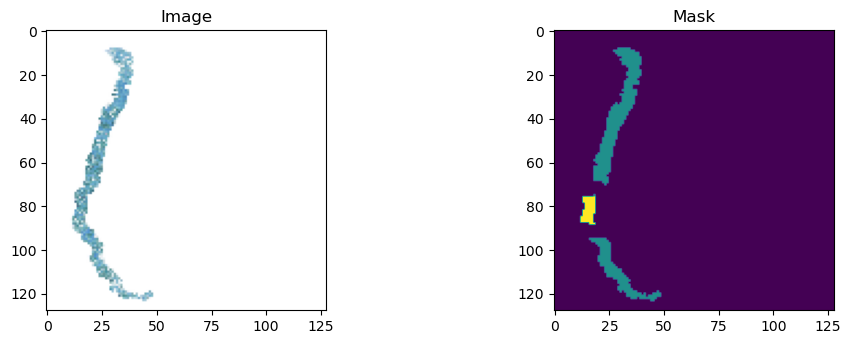

In [36]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[img_number]
mask = train_masks[img_number]
print(img_number)

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [37]:
x_train , x_val, y_train , y_val = train_test_split(train_images,train_masks, test_size = 0.2,random_state = 42)

In [38]:
print(len(x_train) , len(x_val), len(y_train) ,len( y_val))

4800 1200 4800 1200


In [39]:
x_train = pre_inputs(x_train)
x_val = pre_inputs(x_val)


In [40]:
model = sm.Unet(BACKBONE,encoder_weights = y.all())
model.compile(optimizer = 'adam', loss =sm.losses.bce_jaccard_loss, metrics = ['accuracy'] )

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [42]:
#early stoping
es = EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience=5,verbose=1, mode='auto')
# check point
mc = ModelCheckpoint(monitor='val_accuracy', filepath="/kaggle/working/bestmodel.h5", verbose=1, save_best_only=True, mode= 'auto')

cd= [es,mc]

In [43]:
history = model.fit(x_train,y_train, batch_size =1, epochs= 30, verbose=1, validation_data=(x_val,y_val), callbacks= cd)

Epoch 1/30
4800/4800 [==============================] - ETA: 0s - loss: 1.0031 - accuracy: 0.8805
Epoch 1: val_accuracy improved from -inf to 0.87726, saving model to /kaggle/working/bestmodel.h5
4800/4800 [==============================] - 169s 29ms/step - loss: 1.0031 - accuracy: 0.8805 - val_loss: 1.0017 - val_accuracy: 0.8773
Epoch 2/30
4800/4800 [==============================] - ETA: 0s - loss: 1.0005 - accuracy: 0.8806
Epoch 2: val_accuracy did not improve from 0.87726
4800/4800 [==============================] - 138s 29ms/step - loss: 1.0005 - accuracy: 0.8806 - val_loss: 1.0022 - val_accuracy: 0.8773
Epoch 3/30
4800/4800 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.8806
Epoch 3: val_accuracy did not improve from 0.87726
4800/4800 [==============================] - 139s 29ms/step - loss: 1.0004 - accuracy: 0.8806 - val_loss: 1.0032 - val_accuracy: 0.8773
Epoch 4/30
4800/4800 [==============================] - ETA: 0s - loss: 1.0003 - accuracy: 0.8806


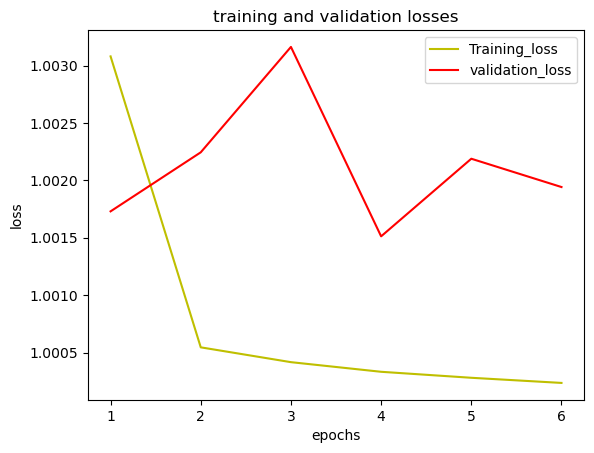

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss, 'y', label = 'Training_loss')
plt.plot(epochs,val_loss, 'r', label = 'validation_loss')
plt.title('training and validation losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


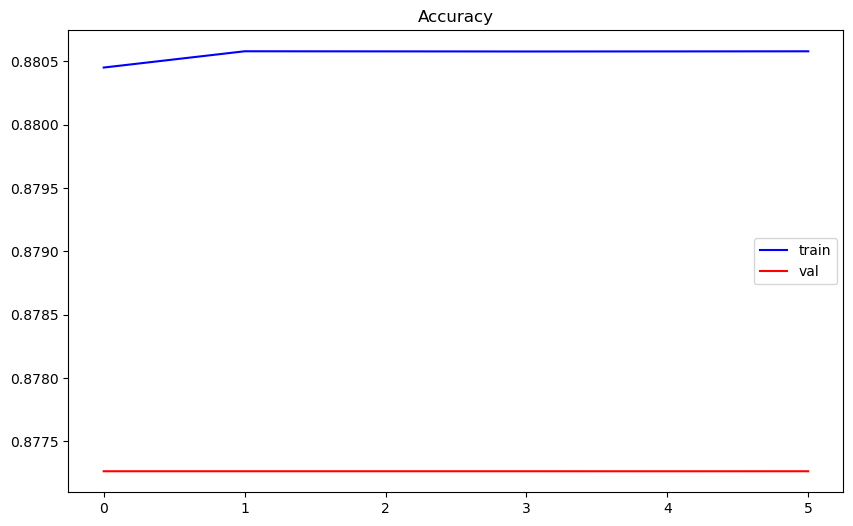

In [45]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()
  
plot_accuracy(history)

In [46]:
#Capture training image info as a list
test_images = []
def read_img_test(x): 
        img = cv2.imread(x,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(128,128))
        img = img/255  # type: ignore
        test_images.append(img)

In [47]:
read_img_test('/kaggle/input/panda2/train_images/040847f885854a69d231c46196288d46.png')

In [48]:
test_images = np.array(test_images)

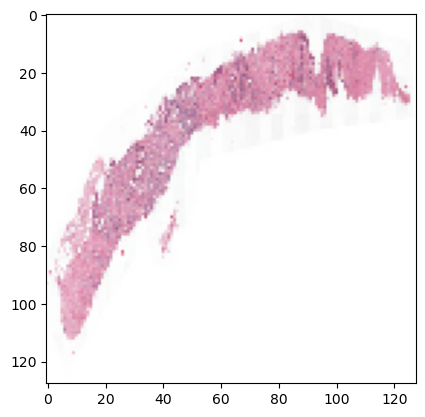

In [49]:
plt.imshow(test_images[0])

1/1 [==============================] - 1s 763ms/step


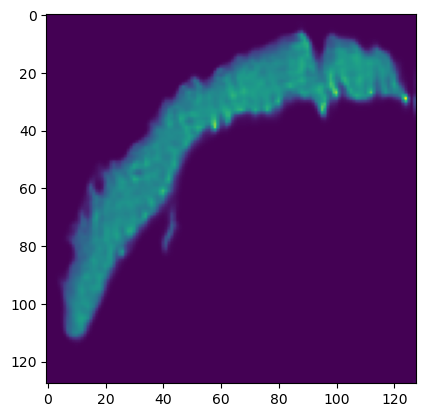

In [50]:
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/bestmodel.h5', compile=False)

prediction = model.predict(test_images)
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image)
plt.show()